In [5]:
from plotly.offline import iplot
import plotly.graph_objs as go
import plotly

from pycpd import deformable_registration

import numpy as np
import numpy.matlib

plotly.offline.init_notebook_mode()

from dataReader import primaryRead, XYZ, rotation
from pivotCalibration import pivotCalib

from VizTool import visualize


In [6]:
data = primaryRead('Data/pc.txt')

pos = XYZ(data[1])
start = 420
end = len(pos) - 250

pos = XYZ([data[1][i] for i in range(start, end)])
print(len(pos),(pos[0].shape))


x = [pos[i][0,0] for i in range(0, len(pos))]
y = [pos[i][0,1] for i in range(0, len(pos))]
z = [pos[i][0,2] for i in range(0, len(pos))]

rot = rotation([data[1][i] for i in range(start, end)])
print(len(rot),(rot[0].shape))

p_tip, p_dimple = pivotCalib(pos,rot)

518 (1, 3)
518 (3, 3)


In [7]:
flat = primaryRead('Data/flat_gel.txt')
curv = primaryRead('Data/curv_gel.txt')
sshape = primaryRead('Data/sshape_gel.txt')

flat_pos = XYZ(flat[1])
flat_rot = rotation(flat[1])

curv_pos = XYZ(curv[1])
curv_rot = rotation(curv[1])

sshape_pos = XYZ(sshape[1])
sshape_rot = rotation(sshape[1])

flat_trans = []
curv_trans = []
sshape_trans = []

for i in range(len(flat_pos)):
    flat_trans.append( flat_pos[i] + (flat_rot[i] * p_tip).T )
    
for i in range(len(curv_pos)):
    curv_trans.append( curv_pos[i] + (curv_rot[i] * p_tip).T )
    
for i in range(len(sshape_pos)):
    sshape_trans.append( sshape_pos[i] + (sshape_rot[i] * p_tip).T )

visualize([flat_trans[200:-320]])
visualize([curv_trans[95:-120]])
visualize([sshape_trans[130:-80]])



In [8]:
%matplotlib inline
from functools import partial
from scipy.io import loadmat
#import matplotlib as mpl
#mpl.use('TkAgg')
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pycpd import deformable_registration, affine_registration
import numpy as np
import time

In [10]:
def visualize2(iteration, error, X, Y, ax):
    plt.cla()
    ax.scatter(X[:,0],  X[:,1], X[:,2], color='red')
    ax.scatter(Y[:,0],  Y[:,1], Y[:,2], color='blue')
    plt.draw()
    print("iteration %d, error %.5f" % (iteration, error))
    plt.pause(0.001)

def defCPD(): 
    flat = np.array(flat_trans[200:-320])
    flat = flat.reshape((np.size(flat,0), np.size(flat,2)))
    #print(np.shape(flat))

    curv = np.array(curv_trans[95:-120])
    curv = curv.reshape((np.size(curv,0), np.size(curv,2)))

    sshape = np.array(sshape_trans[130:-80])
    sshape = sshape.reshape((np.size(sshape,0), np.size(sshape,2)))

    A = np.zeros((flat.shape[0], flat.shape[1] + 1))
    A[:,:-1] = flat
    np.savetxt('flatTransGel.txt', A[:,:-1], fmt='%f')

    B = np.zeros((curv.shape[0], curv.shape[1] + 1))
    B[:,:-1] = curv
    #np.savetxt('curvTrans.txt', B[:,:-1], fmt='%f')


    C = np.zeros((sshape.shape[0], sshape.shape[1] + 1))
    C[:,:-1] = sshape
    np.savetxt('sshapeTransGel.txt', C[:,:-1], fmt='%f')


    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    callback = partial(visualize2, ax=ax)
        
    reg = deformable_registration(B, A, tolerance=0.01)
    ret, blah = reg.register(callback)
    plt.show()
    return ret

def affCPD(): 
    flat = np.array(flat_trans[200:-320])
    flat = flat.reshape((np.size(flat,0), np.size(flat,2)))
    #print(np.shape(flat))

    curv = np.array(curv_trans[95:-120])
    curv = curv.reshape((np.size(curv,0), np.size(curv,2)))

    sshape = np.array(sshape_trans[130:-80])
    sshape = sshape.reshape((np.size(sshape,0), np.size(sshape,2)))

    A = np.zeros((flat.shape[0], flat.shape[1]))
    A[:,:] = flat
    np.savetxt('flatGel.txt', A, fmt='%f')

    B = np.zeros((curv.shape[0], curv.shape[1]))
    B[:,:] = curv
    #np.savetxt('curvTrans.txt', B, fmt='%f')


    C = np.zeros((sshape.shape[0], sshape.shape[1]))
    C[:,:] = sshape
    np.savetxt('sshapeGel.txt', C, fmt='%f')


    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    callback = partial(visualize2, ax=ax)

    reg = affine_registration(B, A, tolerance=1)
    ret, blah, blah2 = reg.register(callback)
    plt.show()
    return ret

iteration 1, error 972.87891


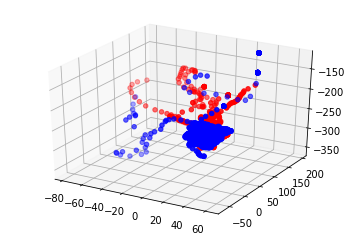

iteration 2, error 21.45048


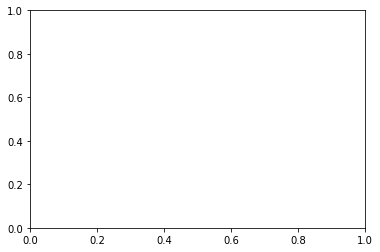

iteration 3, error 0.40019


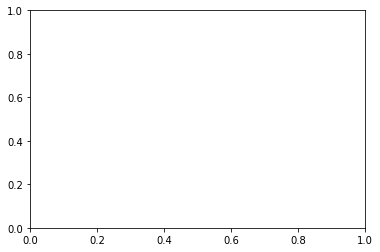

iteration 4, error 0.00522


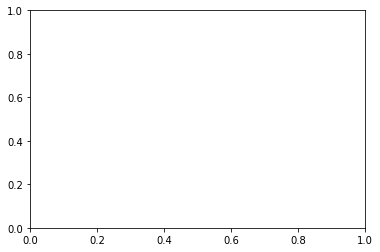

array([[  33.18250631,  -12.14533684, -206.70563256,    0.        ],
       [  33.31564708,  -11.27566362, -207.07529114,    0.        ],
       [  33.62170852,  -10.48748845, -207.14155618,    0.        ],
       ..., 
       [  47.77148513,  -51.65743946, -259.63556508,    0.        ],
       [  47.93903951,  -51.01825733, -259.47737883,    0.        ],
       [  47.88905496,  -50.24969527, -259.74913217,    0.        ]])

In [11]:
defCPD()

In [41]:
ty = np.loadtxt('data/testGel.txt', dtype=float)    
out = []
for row in ty:
    out.append(  np.matlib.matrix( [float(row[i]) for i in range(3)] )  )
visualize([out, flat_trans[0:-70], sshape_trans[95:-120]])

In [49]:
# Checking how well B fits to A, A and B are lists of numpy matricies
def corres(A, B):
    n = len(A)
    thresh = 3
    numNonFit = 0
    for point in B:
        if closePoint(point, A) > thresh:
            numNonFit += 1
        
    return 1 - numNonFit / n

def closePoint(p1, cloud):
    minDist = float("inf")
    for p2 in cloud:
        newDist = numpy.linalg.norm(p1-p2)
        if newDist < minDist:
            minDist = newDist
    return minDist
            
        

In [50]:
print(corres(sshape_trans[130:-80],ty))

0.7211413748378729
